# --- Phase 5: Visualization & Communication ---  

This notebook serves as a guide for conceptualizing and building the interactive dashboard using Streamlit. It demonstrates how to load the trained model and feature-engineered data, and how to extract key insights for visualization. The actual Streamlit application code will reside in src/visualization_app.py.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib # To load the saved model

# For Streamlit app, you'd import streamlit as st and plotly.express as px
# import streamlit as st
# import plotly.express as px

# Set display options for better viewing
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


# --- 1. Load Feature-Engineered Data and Trained Model ---

In [2]:
features_data_path = '../data/processed/customer_churn_features.csv'
try:
    df_features = pd.read_csv(features_data_path)
    print(f"\nSuccessfully loaded feature-engineered data from {features_data_path}")
    print(f"Feature data shape: {df_features.shape}")
except FileNotFoundError:
    print(f"Error: Feature-engineered data file not found at {features_data_path}. Please ensure 02_feature_engineering.ipynb was run successfully.")
    df_features = pd.DataFrame()
except Exception as e:
    print(f"An error occurred while loading feature data: {e}")
    df_features = pd.DataFrame()


Successfully loaded feature-engineered data from ../data/processed/customer_churn_features.csv
Feature data shape: (5281, 16)


In [3]:
# Load the best trained model from 03_model_training_and_evaluation.ipynb
model_path = '../models/best_churn_model.joblib'
try:
    model = joblib.load(model_path)
    print(f"\nSuccessfully loaded trained model from {model_path}")
    print(f"Model type: {type(model)}")
except FileNotFoundError:
    print(f"Error: Model file not found at {model_path}. Please ensure 03_model_training_and_evaluation.ipynb was run successfully and the model was saved.")
    model = None
except Exception as e:
    print(f"An error occurred while loading the model: {e}")
    model = None


Successfully loaded trained model from ../models/best_churn_model.joblib
Model type: <class 'sklearn.ensemble._gb.GradientBoostingClassifier'>


# --- 2. Prepare Data for Prediction (similar to model training) ---

In [4]:
# Drop Customer ID and target variable from features for prediction
# Ensure columns match the training data used for the model
X_predict = df_features.drop(['Customer ID', 'is_churned'], axis=1)

# Make predictions (probabilities are useful for risk scores)
df_features['churn_probability'] = model.predict_proba(X_predict)[:, 1]
df_features['predicted_churn'] = model.predict(X_predict)

print("\n--- Data with Churn Predictions (first 5 rows) ---")
df_features.head()


--- Data with Churn Predictions (first 5 rows) ---


,Customer ID,Monetary,Frequency,Recency,Tenure,is_churned,Country_Belgium,Country_France,Country_Germany,Country_Netherlands,Country_Other,Country_Portugal,Country_Spain,Country_Sweden,Country_Switzerland,Country_United Kingdom,churn_probability,predicted_churn
0,12346,77556.46,12,235,635,1,False,False,False,False,False,False,False,False,False,True,0.446600,0
1,12347,3402.39,6,39,313,0,False,False,False,False,True,False,False,False,False,False,0.218873,0
2,12348,1709.40,4,158,347,0,False,False,False,False,True,False,False,False,False,False,0.509043,1
3,12349,2671.14,3,317,498,0,False,False,False,False,True,False,False,False,False,False,0.709386,1
4,12350,334.40,1,219,219,1,False,False,False,False,True,False,False,False,False,False,0.828715,1


# --- 3. Extracting Key Insights for Dashboard ---

In [5]:
overall_churn_rate = df_features['is_churned'].mean() * 100
predicted_churn_rate = df_features['predicted_churn'].mean() * 100
print(f"\nOverall Actual Churn Rate: {overall_churn_rate:.2f}%")
print(f"Overall Predicted Churn Rate: {predicted_churn_rate:.2f}%")


Overall Actual Churn Rate: 56.60%
Overall Predicted Churn Rate: 61.88%


In [6]:
# Reconstruct the original grouped country column for better visualization
# We will need to re-create this based on the one-hot encoded columns
# Find all 'Country_' columns except 'Country_Other' if it exists and pick the most probable one
country_cols = [col for col in df_features.columns if col.startswith('Country_') and col != 'Country_Other']
if 'Country_Other' in df_features.columns:
    # If 'Country_Other' is 1, it's 'Other', otherwise find the specific country
    def get_original_country(row):
        if row.get('Country_Other', 0) == 1:
            return 'Other'
        for col in country_cols:
            if row[col] == 1:
                return col.replace('Country_', '')
        return 'Unknown'
    df_features['PrimaryCountry_Grouped_Original'] = df_features.apply(get_original_country, axis=1)
else: # If 'Country_Other' doesn't exist, assume all are specific countries
    def get_original_country_no_other(row):
        for col in country_cols:
            if row[col] == 1:
                return col.replace('Country_', '')
        return 'Unknown' # Fallback
    df_features['PrimaryCountry_Grouped_Original'] = df_features.apply(get_original_country_no_other, axis=1)

In [7]:
churn_by_country = df_features.groupby('PrimaryCountry_Grouped_Original')['is_churned'].mean().sort_values(ascending=False) * 100
print("\n--- Churn Rate by Country Group ---")
churn_by_country


--- Churn Rate by Country Group ---


PrimaryCountry_Grouped_Original
Sweden            73.684211
Netherlands       72.727273
Other             64.788732
Portugal          60.000000
Unknown           57.142857
United Kingdom    56.855006
Spain             54.545455
Switzerland       50.000000
France            43.589744
Belgium           40.740741
Germany           40.217391
Name: is_churned, dtype: float64

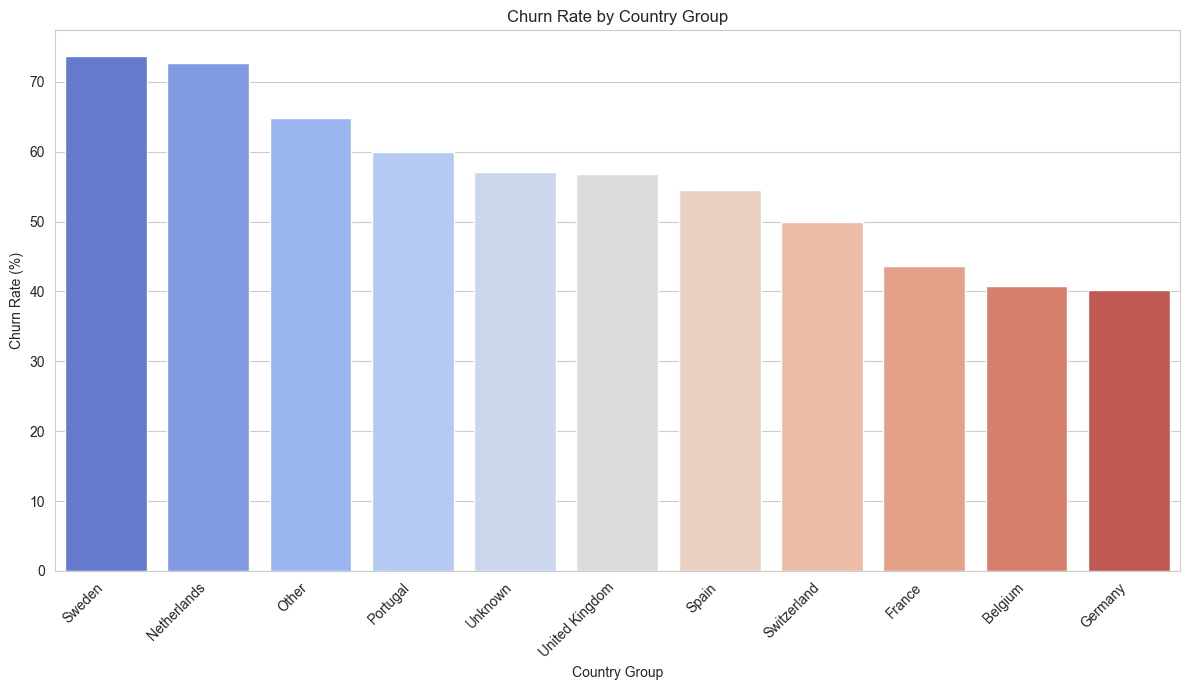

In [8]:
plt.figure(figsize=(12, 7))
sns.barplot(x=churn_by_country.index, y=churn_by_country.values, palette='coolwarm',hue=churn_by_country.index, legend=False) # Fix for FutureWarning
plt.title('Churn Rate by Country Group')
plt.xlabel('Country Group')
plt.ylabel('Churn Rate (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


--- Feature Importance from the Tuned Model ---
                   Feature  Importance
2                  Recency    0.553570
1                Frequency    0.189671
0                 Monetary    0.175155
3                   Tenure    0.071545
8            Country_Other    0.002780
12     Country_Switzerland    0.001727
10           Country_Spain    0.001724
13  Country_United Kingdom    0.001191
6          Country_Germany    0.000879
9         Country_Portugal    0.000744


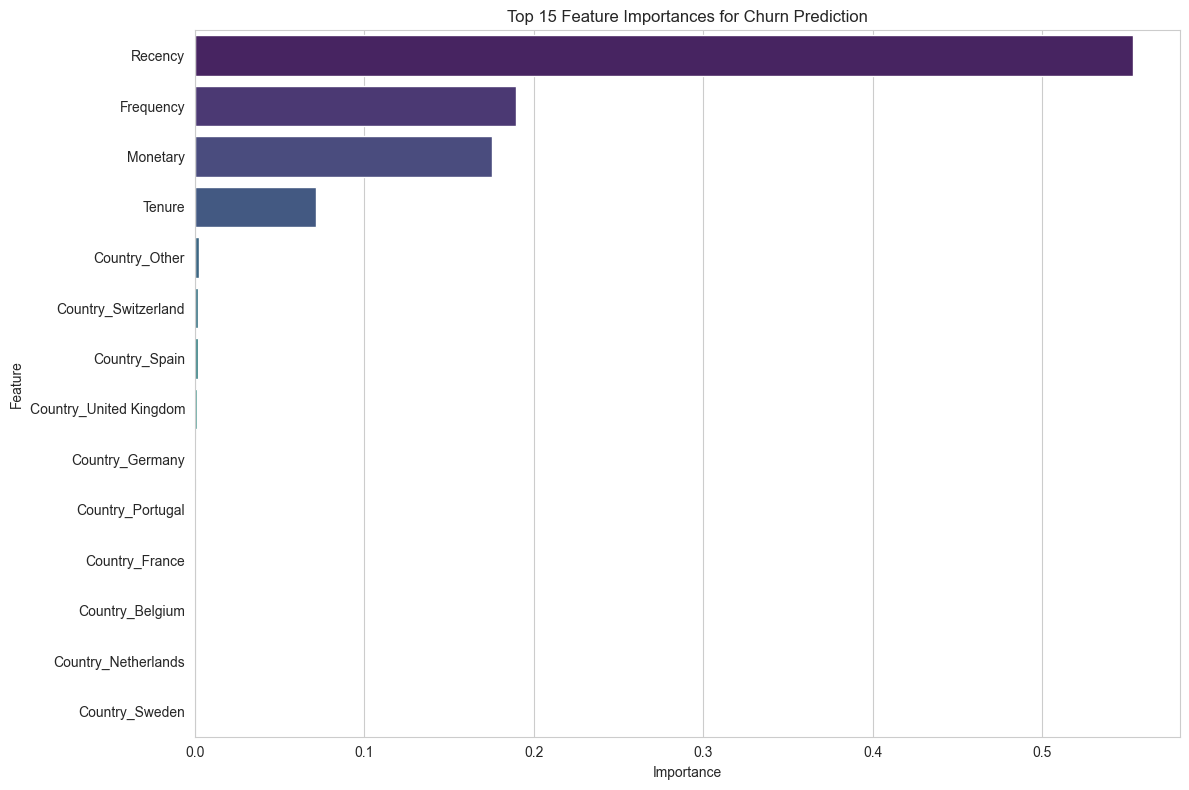

In [9]:
print("\n--- Feature Importance from the Tuned Model ---")
if hasattr(model, 'feature_importances_'):
    importances = model.feature_importances_
    feature_names = X_predict.columns
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    print(feature_importance_df.head(10))

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15), palette='viridis',
                hue='Feature', legend=False) # Fix for FutureWarning
    plt.title('Top 15 Feature Importances for Churn Prediction')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
else:
    print("Feature importances not available for this model type (e.g., Logistic Regression coefficients are interpreted differently).")


In [10]:
# Define a threshold for "high risk" (e.g., churn probability > 0.5 or a value that yields a manageable list)
churn_threshold = 0.5 # This can be adjusted based on business needs (e.g., if you want to be more aggressive)
at_risk_customers = df_features[df_features['churn_probability'] >= churn_threshold].sort_values(by='churn_probability', ascending=False)

In [11]:
print(f"\n--- Top 10 At-Risk Customers (based on probability >= {churn_threshold}) ---")
# Display relevant columns for identifying at-risk customers
# We'll include the original Customer ID for identification
print(at_risk_customers[['Customer ID', 'Recency', 'Frequency', 'Monetary', 'Tenure', 'PrimaryCountry_Grouped_Original', 'churn_probability', 'predicted_churn']].head(10))

print(f"\nTotal at-risk customers identified: {len(at_risk_customers)}")


--- Top 10 At-Risk Customers (based on probability >= 0.5) ---
      Customer ID  Recency  Frequency  Monetary  Tenure PrimaryCountry_Grouped_Original  churn_probability  predicted_churn
3027        15760      540          2  13916.34     540                           Other           0.947319                1
54          12404      591          1     63.24     591                           Other           0.943052                1
3283        16047      591          1    107.14     591                           Other           0.940623                1
499         12918      535          1  10953.50     535                  United Kingdom           0.933651                1
3349        16118      562          1   4376.25     562                  United Kingdom           0.933062                1
251         12636      648          1    141.00     648                           Other           0.932866                1
114         12470      599          1    211.95     599             

# --- 4. Prepare for Streamlit App Development (src/visualization_app.py) ---

In [12]:
print("\n--- Preparing for Streamlit Application ---")
print("The insights gathered above will be integrated into an interactive Streamlit dashboard.")
print("This dashboard will allow users to:")
print(" - View overall churn rates and predicted churn rates.")
print(" - Explore churn rates by different segments (e.g., country).")
print(" - Understand the main drivers of churn.")
print(" - See a list of high-risk customers for targeted interventions.")
print("The code for the Streamlit app will be placed in `src/visualization_app.py`.")

# Save the dataframe with predictions for the Streamlit app to load easily
df_features.to_csv('../data/processed/customer_churn_predictions.csv', index=False)
print("\nDataFrame with churn predictions saved to: ../data/processed/customer_churn_predictions.csv")

# --- End of Notebook 04 ---



--- Preparing for Streamlit Application ---
The insights gathered above will be integrated into an interactive Streamlit dashboard.
This dashboard will allow users to:
 - View overall churn rates and predicted churn rates.
 - Explore churn rates by different segments (e.g., country).
 - Understand the main drivers of churn.
 - See a list of high-risk customers for targeted interventions.
The code for the Streamlit app will be placed in `src/visualization_app.py`.

DataFrame with churn predictions saved to: ../data/processed/customer_churn_predictions.csv
